In [7]:
import ultraplot as uplt
import xarray as xr
import pandas as pd
import os
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image

In [18]:
ds_asi = xr.open_dataset('/Users/dwatkin2/Documents/research/data/ASI_SIC/asi-AMSR2-n6250-2013/asi-AMSR2-n6250-20130424-v5.4.nc')

In [19]:
ds_nsidc = xr.open_dataset('/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr_v4/2013/seaice_conc_daily_nh_20130424_f17_v04r00.nc')

In [86]:
ref_img = rio.open('../data/validation_images/20130424/20130424.aqua.truecolor.250m.tiff')
lab_img = rio.open('../data/validation_images/20130424/20130424.aqua.labeled_clean.250m.tiff')
left, bottom, right, top = ref_img.bounds
tc_img = reshape_as_image(ref_img.read())
labels = reshape_as_image(lab_img.read())

In [59]:
n, m = ref_img.shape
X = np.linspace(left, right, m)
Y = np.linspace(bottom, top, n)

In [32]:
asi_sel = ds_asi.sel(x=slice(left, right), y=slice(bottom, top))
nsidc_sel = ds_nsidc.sel(x=(ds_nsidc.xgrid > left) & (ds_nsidc.xgrid < right),
                         y=(ds_nsidc.ygrid > bottom) & (ds_nsidc.ygrid < top))

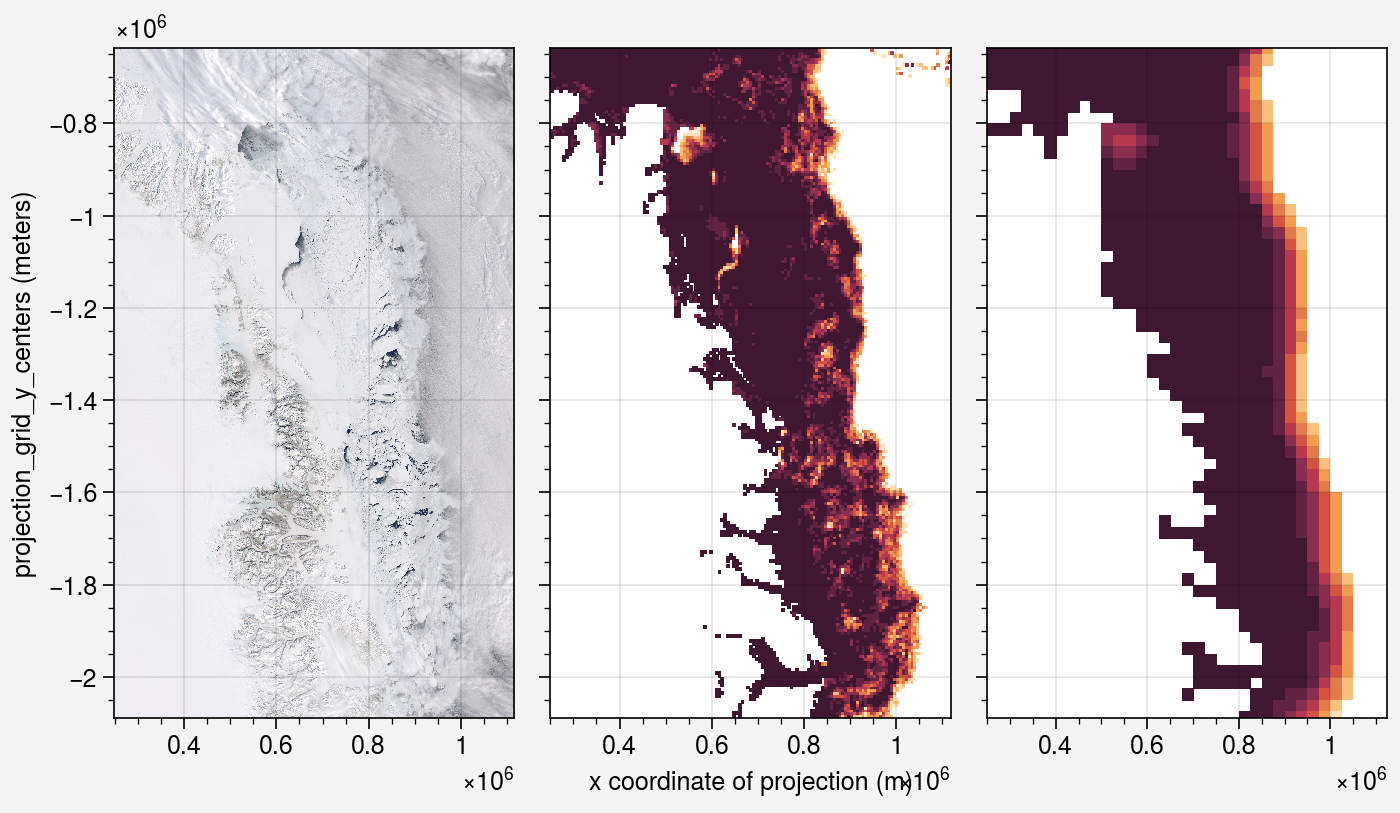

In [53]:
fig, ax = uplt.subplots(width=7, ncols=3)
ax[1].pcolormesh(asi_sel.x, asi_sel.y, asi_sel['z'], vmin=0, vmax=100)
data = nsidc_sel['cdr_seaice_conc'].squeeze()
ax[2].pcolormesh(nsidc_sel.xgrid, nsidc_sel.ygrid, data.where(data <= 1))
ax[0].imshow(tc_img, extent=[left, right, bottom, top])
ax.format(yreverse=False)

In [72]:
test = asi_sel.interp({'x': X, 'y': Y}, method='nearest')

In [74]:
test.compute()

<xarray.Dataset> Size: 77MB
Dimensions:              (y: 5680, x: 3392)
Coordinates:
  * y                    (y) float64 45kB -2.09e+06 -2.09e+06 ... -6.358e+05
  * x                    (x) float64 27kB 2.473e+05 2.476e+05 ... 1.116e+06
Data variables:
    polar_stereographic  |S1 1B b''
    z                    (y, x) float32 77MB nan nan nan nan ... nan nan nan nan
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 19:01:18 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

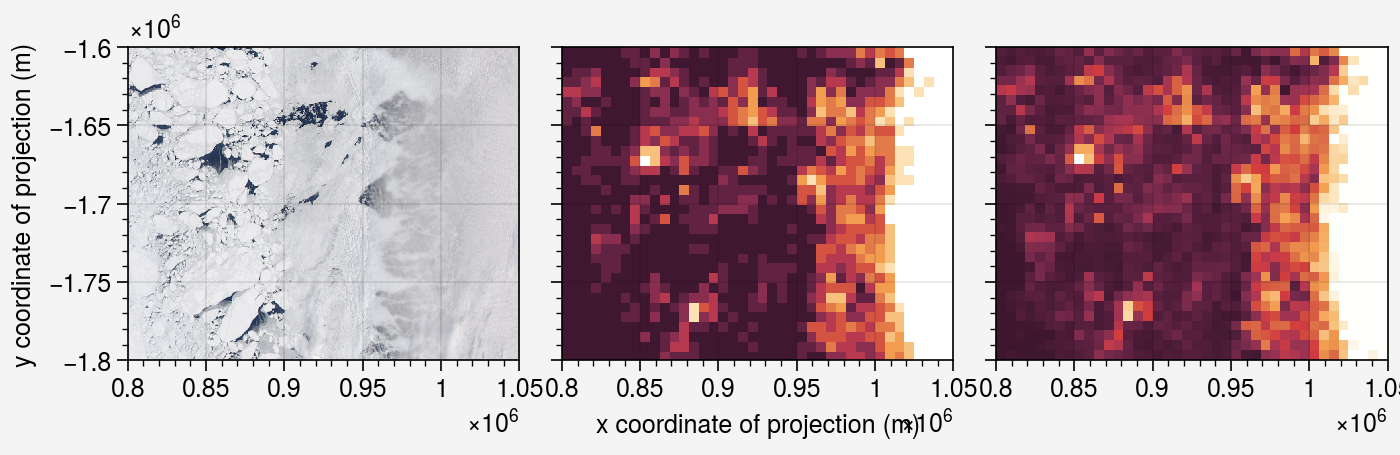

In [78]:
fig, ax = uplt.subplots(width=7, ncols=3)
ax[1].pcolormesh(asi_sel.x, asi_sel.y, asi_sel['z'], vmin=0, vmax=100)
data = nsidc_sel['cdr_seaice_conc'].squeeze()
ax[2].imshow(test['z'], extent=[left, right, top, bottom], vmin=0, vmax=100)
ax[0].imshow(tc_img, extent=[left, right, bottom, top], vmin=0, vmax=100)
ax.format(yreverse=False, ylim=(-1.8e6, -1.6e6), xlim=(0.8e6, 1.05e6))

# What to think about doing:
- Interpolate ASI data to the image resolution
    - Extract features using region props, averaging the values inside the floe
    - Expand boundary by X km, and subtract the original floe. Average values within the band.
- Perform spatial averaging for the SIC prior to looking up the nearest neighbor

In [95]:
smoothed = test.rolling({'x': 100, 'y': 100}, center=True).mean()

In [103]:
coarsened = test.coarsen({'x': 100, 'y': 100}, boundary='trim').mean()

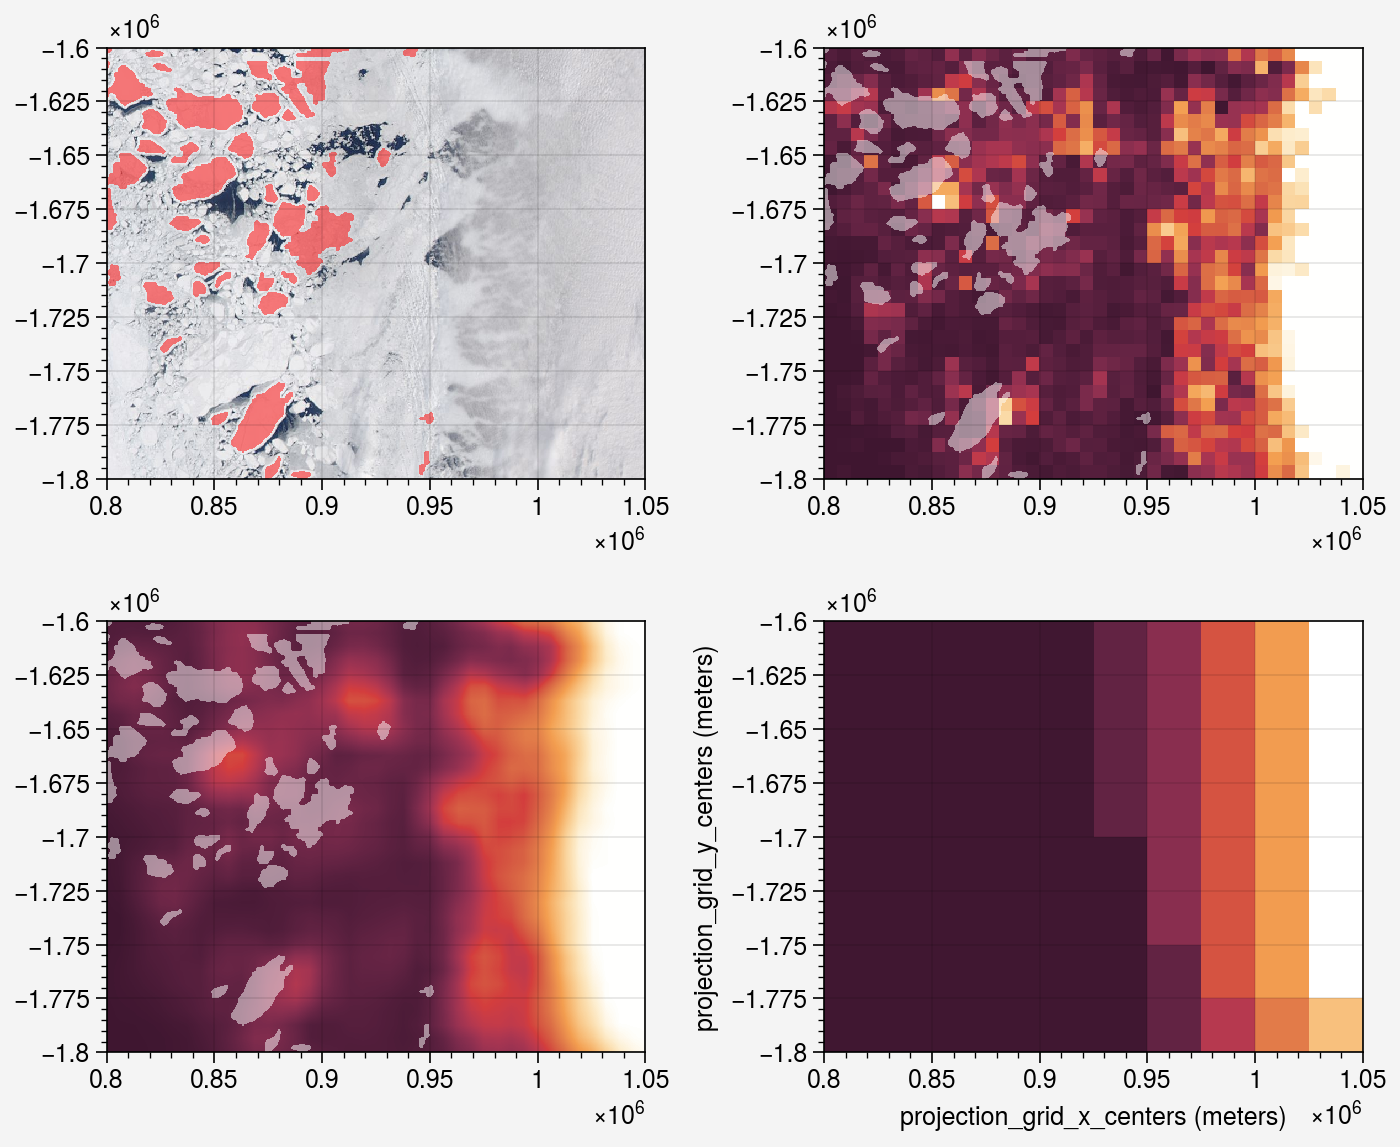

In [100]:
fig, ax = uplt.subplots(width=7, ncols=2, nrows=2, share=False)
ax[0].imshow(tc_img, extent=[left, right, bottom, top])
ax[0].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='r', alpha=0.5)

data = nsidc_sel['cdr_seaice_conc'].squeeze()
ax[3].pcolormesh(nsidc_sel.xgrid, nsidc_sel.ygrid, data.where(data <= 1))
ax[3].format(yreverse=False)

ax[1].imshow(test['z'], extent=[left, right, top, bottom], vmin=0, vmax=100)
ax[1].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='w', alpha=0.5)

ax[2].imshow(smoothed['z'], extent=[left, right, top, bottom], vmin=0, vmax=100)
ax[2].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='w', alpha=0.5)
ax.format(yreverse=False, ylim=(-1.8e6, -1.6e6), xlim=(0.8e6, 1.05e6))

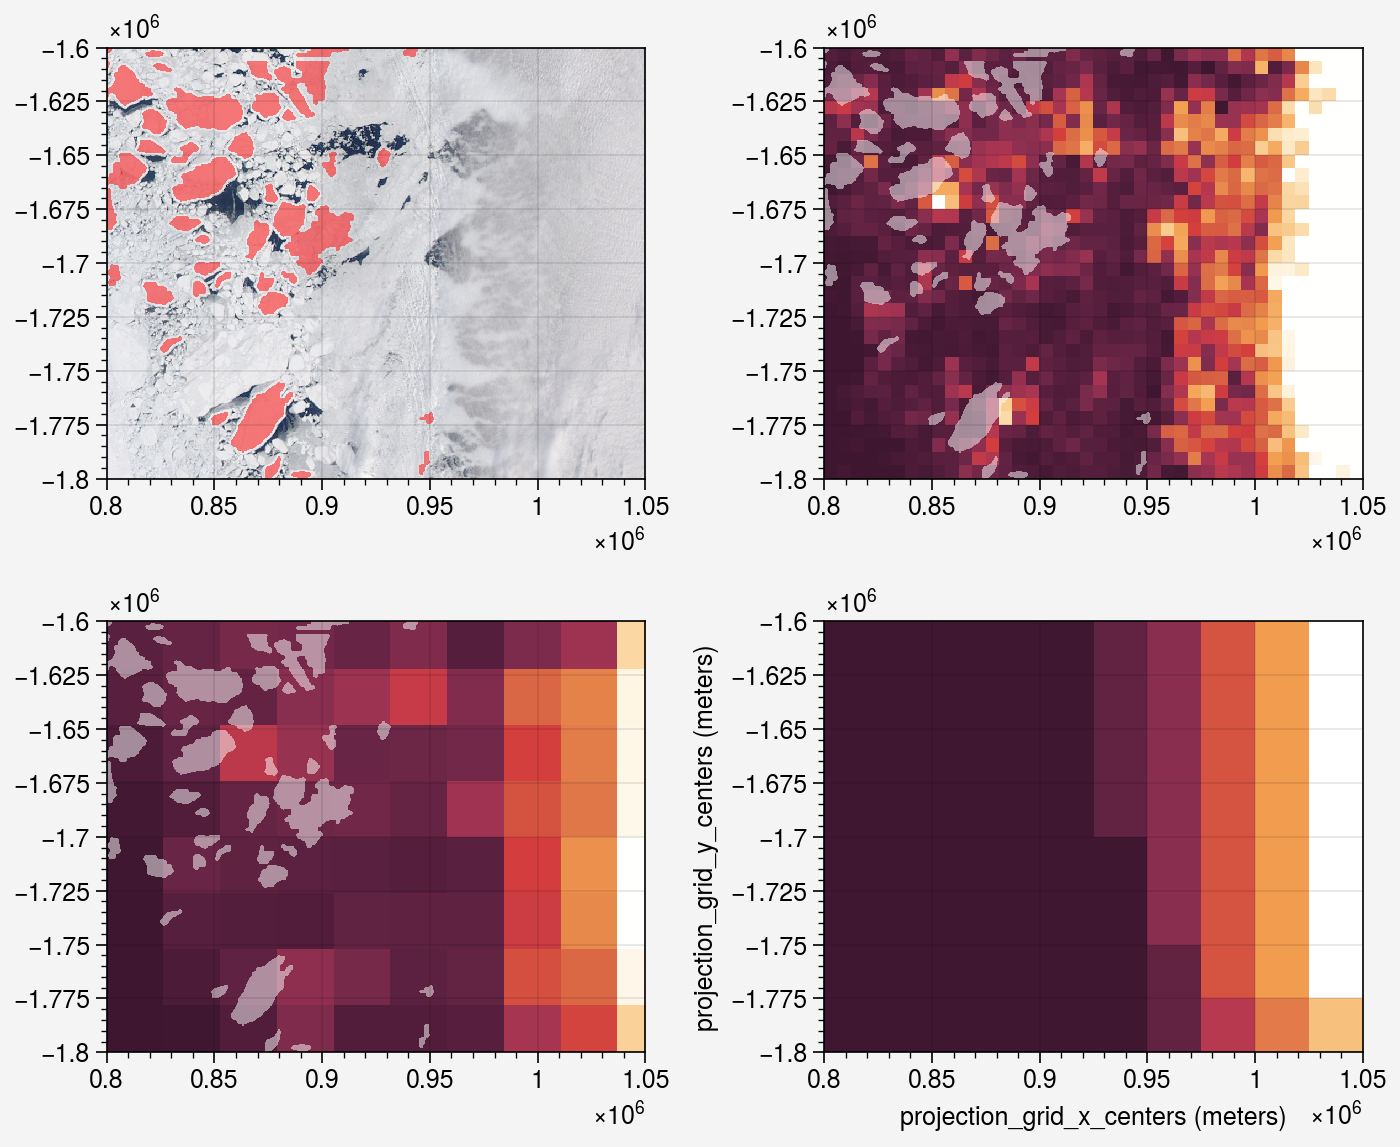

In [104]:
fig, ax = uplt.subplots(width=7, ncols=2, nrows=2, share=False)
ax[0].imshow(tc_img, extent=[left, right, bottom, top])
ax[0].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='r', alpha=0.5)

data = nsidc_sel['cdr_seaice_conc'].squeeze()
ax[3].pcolormesh(nsidc_sel.xgrid, nsidc_sel.ygrid, data.where(data <= 1))
ax[3].format(yreverse=False)

ax[1].imshow(test['z'], extent=[left, right, top, bottom], vmin=0, vmax=100)
ax[1].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='w', alpha=0.5)

ax[2].imshow(coarsened['z'], extent=[left, right, top, bottom], vmin=0, vmax=100)
ax[2].imshow(np.ma.masked_array(labels, labels==0), extent=[left, right, bottom, top], color='w', alpha=0.5)
ax.format(yreverse=False, ylim=(-1.8e6, -1.6e6), xlim=(0.8e6, 1.05e6))